In [0]:
!pip install GPUtil
!pip install tqdm
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi

## Downloading and Generating Dataset


In [0]:
import os
from glob import glob

import cv2
import numpy as np
from tqdm import tqdm

def degrade(path: str) -> None:
    """Load image at `input_path`, distort and save as `output_path`"""
    SHIFT = 2
    image = cv2.imread(path)
    to_swap = np.random.choice([False, True], image.shape[:2], p=[.8, .2])
    swap_indices = np.where(to_swap[:-SHIFT] & ~to_swap[SHIFT:])
    swap_vals = image[swap_indices[0] + SHIFT, swap_indices[1]]
    image[swap_indices[0] + SHIFT, swap_indices[1]] = image[swap_indices]
    image[swap_indices] = swap_vals
    cv2.imwrite(path, image)

!wget http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
!unzip -q pubfig83lfw_raw_in_dirs.zip
!rm pubfig83lfw_raw_in_dirs.zip
!mkdir rephrase-pubfig831
!mv pubfig83lfw_raw_in_dirs rephrase-pubfig831/correct
!rm -r rephrase-pubfig831/correct/distract
!cp -r rephrase-pubfig831/correct rephrase-pubfig831/degraded

for image_path in tqdm(glob('rephrase-pubfig831/degraded/*/*/*.jpg')):
  degrade(image_path)

--2019-10-22 18:54:02--  http://briancbecker.com/files/downloads/pubfig83lfw/pubfig83lfw_raw_in_dirs.zip
Resolving briancbecker.com (briancbecker.com)... 162.241.216.158
Connecting to briancbecker.com (briancbecker.com)|162.241.216.158|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 400247922 (382M) [application/zip]
Saving to: ‘pubfig83lfw_raw_in_dirs.zip’

pubfig83lfw_raw_in_ 100%[===================>] 381.71M  1.33MB/s    in 2m 34s  

2019-10-22 18:56:36 (2.48 MB/s) - ‘pubfig83lfw_raw_in_dirs.zip’ saved [400247922/400247922]

mkdir: cannot create directory ‘rephrase-pubfig831’: File exists
rm: cannot remove 'rephrase-pubfig831/correct/distract': No such file or directory


100%|██████████| 13002/13002 [01:08<00:00, 189.22it/s]


# **Checking Free Memory**
This block is just so that you can have an idea of the resources you have at hand on the Google Collab system.

In [0]:
import psutil
import humanize
import os
import GPUtil as GPU
import tensorflow as tf
gpu = GPU.getGPUs()[0]
process = psutil.Process(os.getpid())
print(f"Gen RAM: Free {humanize.naturalsize(psutil.virtual_memory().available)} | Proc size {humanize.naturalsize(process.memory_info().rss)}")
print(f"GPU RAM: Free {gpu.memoryFree:.0f}MB | Used {gpu.memoryUsed:.0f}MB | Util {gpu.memoryUtil*100:.0f}% | Total {gpu.memoryTotal:.0f}MB")

Gen RAM: Free 5.2 GB | Proc size 9.0 GB
GPU RAM: Free 401MB | Used 11040MB | Util 96% | Total 11441MB


# **Main Code**

## Data Loading

In [0]:
train_data_arr = []
for img_file in glob('rephrase-pubfig831/*/train/*/*'):
    img_name_split = img_file.split("/")
    deg_corr_key = img_name_split[1]
    name = img_name_split[-1]

    if len(train_data_arr) == 0:
        train_data_arr.append({deg_corr_key: img_file, "name": name})
    found = False
    for image_dic in train_data_arr:
        if image_dic["name"] == name:
            image_dic[deg_corr_key] = img_file
            found = True
            break
    if not found:
        train_data_arr.append({deg_corr_key: img_file, "name": name})

test_data_arr = []
for img_file in glob('rephrase-pubfig831/*/test/*/*'):
    img_name_split = img_file.split("/")
    deg_corr_key = img_name_split[1]
    name = img_name_split[-1]

    if len(test_data_arr) == 0:
        test_data_arr.append({deg_corr_key: img_file, "name": name})
    found = False
    for image_dic in test_data_arr:
        if image_dic["name"] == name:
            image_dic[deg_corr_key] = img_file
            found = True
            break
    if not found:
        test_data_arr.append({deg_corr_key: img_file, "name": name})

final_train_data = []
for train_val in train_data_arr:
    temp = []
    temp.append(train_val["correct"])
    temp.append(train_val["degraded"])
    temp.append(train_val["name"])
    final_train_data.append(temp)

final_test_data = []
for test_val in test_data_arr:
    temp = []
    temp.append(test_val["correct"])
    temp.append(test_val["degraded"])
    temp.append(test_val["name"])
    final_test_data.append(temp)

print("All Data Loaded in required format")

All Data Loaded in required format


## Structure

### **Constants and Hyperparemeters**

In [0]:
def make_conv_2d(input, out_dim, name='conv2d'):
    with tf.variable_scope(name):
        weight = tf.get_variable('weight', 
                                 [4, 4, input.get_shape()[-1], out_dim], 
                                 initializer=tf.truncated_normal_initializer(stddev=0.02))
        bias = tf.get_variable('bias', 
                               [out_dim], 
                               initializer=tf.constant_initializer(0.0))
        conv_2d = tf.nn.conv2d(input, 
                               weight, 
                               strides=[1, 2, 2, 1], 
                               padding='SAME')
        return tf.nn.bias_add(conv_2d, bias)

def make_deconv_2d(input, out, name='deconv2d'):
    with tf.variable_scope(name):
        weight = tf.get_variable('weight', 
                                 [4, 4, out[-1], input.get_shape()[-1]], 
                                 initializer=tf.random_normal_initializer(0.02))
        bias = tf.get_variable('bias', 
                               [out[-1]], 
                               initializer=tf.constant_initializer(0.0))
        deconv_2d = tf.nn.conv2d_transpose(input, 
                                           weight, 
                                           output_shape=out, 
                                           strides=[1, 2, 2, 1])
        return tf.nn.bias_add(deconv_2d, bias)

def leaky_relu(val, leaky_val = 0.2):
    return tf.maximum(val, val * leaky_val)

def make_batch_norm(inp, scope, is_train):
    return tf.contrib.layers.batch_norm(inp, 
                                        decay=0.9, 
                                        updates_collections=None, 
                                        epsilon=1e-5, 
                                        scale=True, 
                                        is_training=is_train,
                                        scope = scope)
    

def make_fully_conn_layer(inp, out_dim, scope=None):
    shape = inp.get_shape().as_list()
    with tf.variable_scope(scope or 'fully_connected'):
        weight = tf.get_variable("weight", 
                                 [shape[1], out_dim], 
                                 tf.float32,
                                 tf.random_normal_initializer(stddev=0.02))
        bias = tf.get_variable("bias", 
                               [out_dim], 
                               initializer=tf.constant_initializer(0.0))
        return tf.matmul(inp, weight) + bias


def make_conv_feature(conv, feature_out, name, is_train):
    final_conv = make_conv_2d(leaky_relu(conv), feature_out, name=name)
    return make_batch_norm(final_conv, scope=name, is_train=is_train)


### Generator Model

In [0]:
def generator(image_name_dim, is_train, reuse = False):
    out = 64
    with tf.variable_scope("generator", reuse=tf.AUTO_REUSE) as scope:
        if reuse:
            scope.reuse_variables()
        conv1 = make_conv_2d(image_name_dim, out, name="conv1")
        conv2 = make_conv_feature(conv1, out*2, name="conv2", is_train=is_train)
        conv3 = make_conv_feature(conv2, out*4, name="conv3", is_train=is_train)
        conv4 = make_conv_feature(conv3, out*8, name="conv4", is_train=is_train)
        conv5 = make_conv_feature(conv4, out*8, name="conv5", is_train=is_train)
        conv6 = make_conv_feature(conv5, out*8, name="conv6", is_train=is_train)
        conv7 = make_conv_feature(conv6, out*8, name="conv7", is_train=is_train)
        conv8 = make_conv_feature(conv7, out*8, name="conv8", is_train=is_train)

        image_size = 250
        dim_arr = [0] * 9
        for i in range(1, 9):
            dim_arr[9-i] = image_size
            image_size = (image_size + 1)//2

        deconv1 = make_deconv_2d(tf.nn.relu(conv8), 
                                 [1, dim_arr[1], dim_arr[1], out*8], 
                                 name="deconv1")
        deconv1 = tf.concat([tf.nn.dropout(make_batch_norm(deconv1, scope="deconv1", is_train=is_train), 0.5), conv7], 
                            3, 
                            name = "deconv_concat_1")
        
        deconv2 = make_deconv_2d(tf.nn.relu(deconv1), 
                                 [1, dim_arr[2], dim_arr[2], out*8], 
                                 name="deconv2")
        deconv2 = tf.concat([tf.nn.dropout(make_batch_norm(deconv2, scope="deconv2", is_train=is_train), 0.5), conv6], 
                            3, 
                            name = "deconv_concat_2")
        
        deconv3 = make_deconv_2d(tf.nn.relu(deconv2), 
                                 [1, dim_arr[3], dim_arr[3], out*8], 
                                 name="deconv3")
        deconv3 = tf.concat([tf.nn.dropout(make_batch_norm(deconv3, scope="deconv3", is_train=is_train), 0.5), conv5], 
                            3, 
                            name = "deconv_concat_3")
        
        deconv4 = make_deconv_2d(tf.nn.relu(deconv3), 
                                 [1, dim_arr[4], dim_arr[4], out*8], 
                                 name = "deconv4")
        deconv4 = tf.concat([make_batch_norm(deconv4, scope="deconv4", is_train=is_train), conv4], 
                            3,
                            name="deconv_concat_4")
        
        deconv5 = make_deconv_2d(tf.nn.relu(deconv4), 
                                 [1, dim_arr[5], dim_arr[5], out*4], 
                                 name = "deconv5")
        deconv5 = tf.concat([make_batch_norm(deconv5, scope="deconv5", is_train=is_train), conv3], 
                            3,
                            name="deconv_concat_5")
        
        deconv6 = make_deconv_2d(tf.nn.relu(deconv5), 
                                 [1, dim_arr[6], dim_arr[6], out*2], 
                                 name = "deconv6")
        deconv6 = tf.concat([make_batch_norm(deconv6, scope="deconv6", is_train=is_train), conv2], 
                            3,
                            name="deconv_concat_6")
        
        deconv7 = make_deconv_2d(tf.nn.relu(deconv6), 
                                 [1, dim_arr[7], dim_arr[7], out], 
                                 name = "deconv7")
        deconv7 = tf.concat([make_batch_norm(deconv7, scope="deconv7", is_train=is_train), conv1], 
                            3,
                            name="deconv_concat_7")
        
        deconv8 = make_deconv_2d(tf.nn.relu(deconv7), [1, dim_arr[8], dim_arr[8], 3], name="deconv8")

        return tf.nn.tanh(deconv8)


### Discriminator Model

In [0]:
def discriminator(image, image_name_dim, is_train, reuse=False):
    with tf.variable_scope("discriminator", reuse=tf.AUTO_REUSE):
        image = tf.concat([image, image_name_dim], len(image.get_shape())-1)
        out_dim = 64
        h0 = leaky_relu(make_conv_2d(image, out_dim, name="h0"))
        h1 = leaky_relu(make_batch_norm(make_conv_2d(h0, out_dim*2, name="h1"), scope="h1", is_train=is_train))
        h2 = leaky_relu(make_batch_norm(make_conv_2d(h1, out_dim*4, name="h2"), scope="h2", is_train=is_train))
        h3 = leaky_relu(make_batch_norm(make_conv_2d(h2, out_dim*8, name="h3"), scope="h3", is_train=is_train))
        h4 = make_fully_conn_layer(tf.reshape(h3, [1, -1]), 1, scope="fully_connected")

    return h4

### Loss Functions

In [0]:
def get_discriminator_loss(orig_disc_func, fake_disc_func):
    orig_disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=orig_disc_func, 
                                                                           labels=tf.ones_like(orig_disc_func)))
    fake_disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_disc_func, 
                                                                            labels=tf.zeros_like(fake_disc_func)))
    final_disc_loss = orig_disc_loss + fake_disc_loss

    return final_disc_loss

def get_generator_loss(orig_image, gen_image, fake_disc_func):
    return tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_disc_func, labels=tf.ones_like(fake_disc_func))) + \
                      100 * tf.reduce_mean(tf.abs(orig_image - gen_image))


### Optimizer

In [0]:
def get_disc_optimizer(disc_loss, disc_vars, lr, name):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        return tf.train.AdamOptimizer(learning_rate=lr).minimize(disc_loss, var_list=disc_vars)

def get_gen_optimizer(gen_loss, gen_vars, lr, name):
    with tf.variable_scope(name, reuse=tf.AUTO_REUSE):
        return tf.train.AdamOptimizer(learning_rate=lr).minimize(gen_loss, var_list=gen_vars)

## Preprocessing

### Setting device to use for tensor operations

In [0]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla K80, pci bus id: 0000:00:04.0, compute capability: 3.7



In [0]:
def preprocess_dataset(image, degraded_image):
    image = cv2.resize(image, (250, 250))
    degraded_image = cv2.resize(degraded_image, (250, 250))

    image = image.reshape((1, 250, 250, 3))
    degraded_image = degraded_image.reshape((1, 250, 250, 3))
    
    image = image/127.5 - 1.
    degraded_image = degraded_image/127.5 - 1.

    return image, degraded_image


## Training

In [0]:
def train_CGAN():
    orig_image = tf.placeholder(tf.float32, shape=(1, 250, 250, 3))
    cond_image = tf.placeholder(tf.float32, shape=(1, 250, 250, 3))
    is_train = tf.placeholder(tf.bool, name = "is_train")

    gen_image = generator(cond_image, is_train)

    orig_disc_func = discriminator(orig_image, cond_image, is_train, reuse=False)
    fake_disc_func = discriminator(gen_image, cond_image, is_train, reuse=True)

    disc_loss = get_discriminator_loss(orig_disc_func, fake_disc_func)
    gen_loss = get_generator_loss(orig_image, gen_image, fake_disc_func)

    tf_vars = tf.trainable_variables()
    disc_vars = [var for var in tf_vars if 'discriminator' in var.name]
    gen_vars = [var for var in tf_vars if 'generator' in var.name]

    saver = tf.train.Saver()

    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True

    disc_opt = get_disc_optimizer(disc_loss, disc_vars, 0.0002, name="disc_adam")
    gen_opt = get_gen_optimizer(gen_loss, gen_vars, 0.0002, name="gen_adam")

    init = tf.global_variables_initializer()

    with tf.Session(config=config) as sess:
        sess.run(init)

        for epoch in range(5):
            counter = 0

            for correct_image, degraded_image, image_name in final_train_data:
                
                correct_image = cv2.imread(correct_image)
                degraded_image = cv2.imread(degraded_image)
                
                correct_image, degraded_image = preprocess_dataset(correct_image, degraded_image)
                
                _, m = sess.run([disc_opt, disc_loss], 
                                feed_dict={orig_image: correct_image, cond_image: degraded_image, is_train: True})
                _, M = sess.run([gen_opt, gen_loss], 
                                feed_dict={orig_image: correct_image, cond_image: degraded_image, is_train: True})
                
                counter += 1
                if counter % 50 == 0:
                    print(f"Epoch {epoch}, Iteration {counter}: d_loss: {m}, g_loss: {M}")

            if (epoch + 1) % 1 == 0:
                save_path = saver.save(sess, "checkpoints/" + f"model_{epoch+1}.ckpt")
                eval_testset(final_test_data, epoch+1, sess)

train_CGAN()

Epoch 0, Iteration 50: d_loss: 0.00422100443392992, g_loss: 117.0467529296875
Epoch 0, Iteration 100: d_loss: 1.2156371020921597e-08, g_loss: 108.55809020996094
Epoch 0, Iteration 150: d_loss: 11.42780876159668, g_loss: 104.99324798583984
Epoch 0, Iteration 200: d_loss: 1.3699105868777983e-12, g_loss: 88.44298553466797
Epoch 0, Iteration 250: d_loss: 3.9429465751004446e-16, g_loss: 90.7728271484375
Epoch 0, Iteration 300: d_loss: 5.726040301634594e-14, g_loss: 130.01278686523438
Epoch 0, Iteration 350: d_loss: 5.81890922161166e-17, g_loss: 89.40166473388672
Epoch 0, Iteration 400: d_loss: 1.28189288611108e-13, g_loss: 89.5544204711914
Epoch 0, Iteration 450: d_loss: 2.9964297157246063e-19, g_loss: 85.20977020263672
Epoch 0, Iteration 500: d_loss: 2.635891632962739e-06, g_loss: 69.34146881103516
Epoch 0, Iteration 550: d_loss: 3.221311065115806e-11, g_loss: 76.98585510253906
Epoch 0, Iteration 600: d_loss: 1.182335132196645e-22, g_loss: 128.45791625976562
Epoch 0, Iteration 650: d_loss:

## Evaluation

In [0]:
def eval_testset(final_test_data, epoch, sess):
    count = 0
    for correct_image, degraded_image, image_name in final_test_data[0:5]:
        correct_image = cv2.imread(correct_image)
        degraded_image = cv2.imread(degraded_image)
        
        correct_image, degraded_image = preprocess_dataset(correct_image, degraded_image)
        
        cond_image = tf.placeholder(tf.float32, shape=(1, 250, 250, 3))
        is_train = tf.placeholder(tf.bool, name = "is_train")
        gen_img = generator(cond_image, is_train)

        gen_img = sess.run(gen_img, feed_dict={cond_image: degraded_image, is_train: False})
        gen_img = gen_img.reshape(gen_img.shape[1:])
        gen_img = (gen_img + 1.) * 127.5

        print(degraded_image.shape)
        degraded_image = degraded_image.reshape((250, 250, 3))
        degraded_image = degraded_image/127.5 - 1.
        
        gen_img = np.concatenate((gen_img, degraded_image), axis=1).astype(np.int)
        status = cv2.imwrite(f"checkpoints/{image_name}-epoch-{epoch}-count-{count}.jpg", gen_img)

        count += 1

In [0]:
def fix(image: np.ndarray, sess) -> np.ndarray:
    """
    This function should take a degraded image in BGR format as a 250x250x3
    numpy array, and return its fixed version in the same format.
    """
    
    orig_image = tf.placeholder(tf.float32, shape=(1, 250, 250, 3))
    cond_image = tf.placeholder(tf.float32, shape=(1, 250, 250, 3))
    is_train = tf.placeholder(tf.bool, name = "is_train")
    
    image = image.reshape((1, 250, 250, 3))
    image = image/127.5 - 1.
    gen_img = generator(cond_image, is_train)

    gen_img = sess.run(gen_img, feed_dict={cond_image: image, is_train: False})
    gen_img = gen_img.reshape(gen_img.shape[1:])
    gen_img = (gen_img + 1.) * 127.5

    image = image.reshape((250, 250, 3))
    image = image/127.5 - 1.
    gen_img = np.concatenate((gen_img, image), axis=1).astype(np.int)

    return gen_img


INFO:tensorflow:Restoring parameters from checkpoints/model_5.ckpt


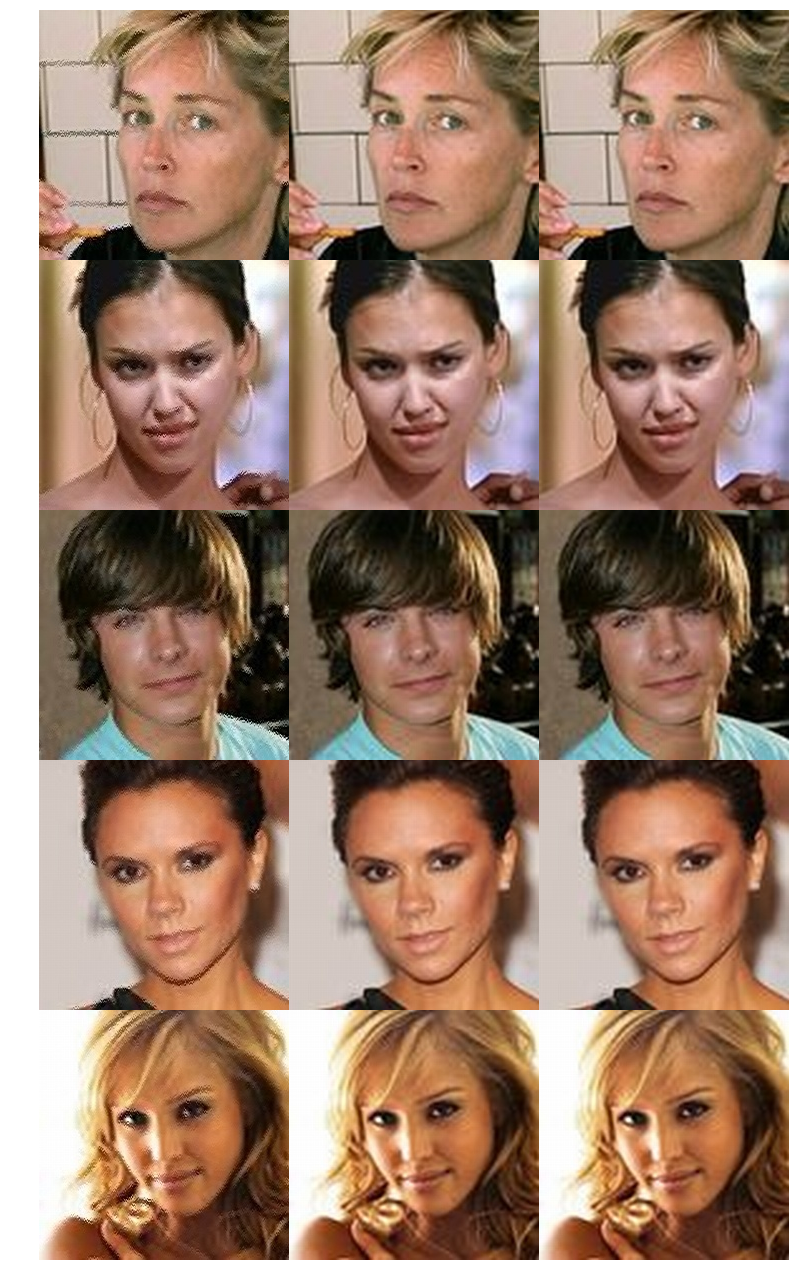

In [0]:
%matplotlib inline

import os
import random
from glob import glob
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

NUM_DISPLAY = 5

files = glob('/content/rephrase-pubfig831/correct/test/*/*')
grid = []

# As the Colab notebook is crashing once I run this cell due to low RAM, 
# I've tweaked a small portion of the below code to get session from the saved checkpoint
# and passing this session to 'fix' function inorder to generate the image from model

sess = tf.Session()
new_saver = tf.train.import_meta_graph('checkpoints/model_5.ckpt.meta')
new_saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))

sess.run(tf.global_variables_initializer())


for path in random.sample(files, NUM_DISPLAY):
  correct = cv2.imread(path)
  split = path.split('/')
  degraded = cv2.imread('/'.join([*split[:3], 'degraded', *split[4:]]))
  fixed = fix(degraded, sess)
  grid.append(np.column_stack([degraded, fixed, correct]))

image = np.row_stack(grid)
dpi = float(plt.rcParams['figure.dpi'])
figsize = image.shape[1] / dpi, image.shape[0] / dpi
ax = plt.figure(figsize=figsize).add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(image[..., ::-1])
plt.show()